In [4]:
import orbipy as op
import numpy as np
import pandas as pd
from numba.core.ir import Raise
from numba.np.arrayobj import np_array
from orbipy import plotter
from orbipy.correction import border_correction, base_correction
from scipy.optimize import bisect
from matplotlib import pyplot as plt
import pickle


In [2]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1-model.L1) / 61.350

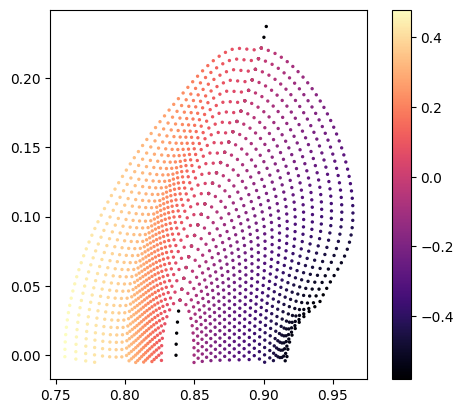

In [6]:

data_zvl = np.load('data/contour_points/zvl/zvl_2.npy')
data_zvl = np.c_[data_zvl, np.zeros(len(data_zvl))]

with open(r"data/contour_points/contour_points_data_3_points.pickle", "rb") as input_file:
    data = pickle.load(input_file)
data_points = []
for line in data:
    for point in line:
        data_points.append(point)
        
data_points = np.array(data_points)

# print(data_points)
plt.scatter(data_zvl[:32,0], data_zvl[:32,1], c=data_zvl[:32,2], cmap='magma', s=2)
plt.scatter(data_points[:,0], data_points[:,1], c=data_points[:,2], cmap='magma', s=2)

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

In [16]:
left = op.eventX(model.L1 - 33 * one_thousand_kms)
right = op.eventX(model.L1 + 53 * one_thousand_kms)


In [49]:
class zero_correction(op.corrections.base_correction):
    def __init__(self, model, direction):
        super().__init__(model, direction)
        
    def calc_dv(self, t, s):
        return model.get_zero_state()
        

In [54]:
first_correction = op.border_correction(model, op.y_direction(), [left], [right])
correction = op.border_correction(model, op.unstable_direction(model), [left], [right])
zcorrection = zero_correction(model, op.unstable_direction(model))
impulse_correction = op.strict_station_keeping(model, zcorrection, correction, rev=np.pi/4)
# correction = op.border_correction(model, op.y_direction(), [left], [right])

s0 = model.get_zero_state()

s0[0] = data[43][40][0]
s0[2] = data[43][40][1]
s0[4] = data[43][40][2]

# s0[0] = 9.660916345280373685e-01 
# s0[2] = 1.441413425661594305e-01
# s0[4] = 0.000012

print(s0)
print(data[43][40])
s0 += first_correction.calc_dv(0, s0)
print(s0)


# df = model.prop(s0, 0, 2*np.pi)
df = impulse_correction.prop(0, s0, 20)

plotter = op.plotter.from_model(model, length_units='Mm', velocity_units='km/s')
ax = plotter.plot_proj(df, centers={'x':model.L1})
plotter.plot_proj(ax=ax, centers={'x':model.L1}, plottables=[plotter.L1], colors='k',ls='',marker='o')



[0.78060754 0.         0.03204176 0.         0.41853367 0.
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.        ]
[0.7806075430215963, 0.03204175740738056, 0.41853366697827654]
[0.78060754 0.         0.03204176 0.         0.44818079 0.
 1.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         1.        ]
Simple station-keeping: 0 1 

capi_return is NULL
Call-back cb_solout_in___user__routines failed.


KeyboardInterrupt: 